In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Energy.HelpFunctions.get_energy_data import get_energy_data, prepare_data
from Energy.HelpFunctions.date_and_time import most_recent_thursday, split_time
from Energy.Models.baseline import baseline
from Energy.HelpFunctions.calc_score import evaluate_horizon
from Energy.Models.Model1 import model1

# import importlib
# importlib.reload(Energy.Models)

In [3]:
df = get_energy_data()
df = prepare_data(df)

100%|██████████| 256/256 [00:43<00:00,  5.90it/s]


In [ ]:
# baseline(df, LAST_IDX=-1)
# model1(df)

# Cross validate

Remove everything til last thursday night 12pm

In [4]:
start_date_excl = most_recent_thursday(df)
df_cval = df.loc[df.index < start_date_excl]

In [6]:
# baseline(df_cval, LAST_IDX=-1)
model1(df_cval)

                     weekday  hour  month  winter  low_consumption_time  \
date_time                                                                 
2023-11-09 00:00:00        3     0     11       1                     1   
2023-11-09 01:00:00        3     1     11       1                     1   
2023-11-09 02:00:00        3     2     11       1                     1   
2023-11-09 03:00:00        3     3     11       1                     1   
2023-11-09 04:00:00        3     4     11       1                     1   
...                      ...   ...    ...     ...                   ...   
2023-11-17 03:00:00        4     3     11       1                     1   
2023-11-17 04:00:00        4     4     11       1                     1   
2023-11-17 05:00:00        4     5     11       1                     1   
2023-11-17 06:00:00        4     6     11       1                     1   
2023-11-17 07:00:00        4     7     11       1                     0   

                     hig

,forecast_date,q0.025,q0.25,q0.5,q0.75,q0.975
0,2023-11-10 12:00:00,51.117004,63.483001,67.313252,70.632750,75.347749
1,2023-11-10 16:00:00,51.117004,63.483001,67.313252,70.632750,75.347749
2,2023-11-10 20:00:00,46.923001,56.038000,60.062752,63.489500,68.797452
3,2023-11-11 12:00:00,44.053504,53.248750,57.490751,61.055501,65.705296
4,2023-11-11 16:00:00,44.053504,53.248750,57.490751,61.055501,65.705296
5,2023-11-11 20:00:00,39.859501,45.803750,50.240250,53.912251,59.154999


Repeatedly run the model. Record predictions and true values (observations). Make sure the observations are available for the most recent prediction.

In [15]:
evaluation = pd.DataFrame()
df_before = df_cval
for w in range(100):
    # Create a temp df that only contains the values used for training
    df_before, df_after = split_time(df_before, num_weeks=1)
    pred = baseline(df_before, LAST_IDX=-1)
    # pred = model1(df_before)
    # Transform the observations to timeseries with same index and then merge
    obs = pd.DataFrame({'gesamt': df_cval.loc[pred['forecast_date']]["gesamt"]})
    obs = obs.rename_axis('forecast_date')
    pred = pred.set_index('forecast_date')
    # print(pred.iloc[0]['q0.025','q0.25'])
    merged_df = pd.merge(pred, obs, left_index=True, right_index=True) 
    
    # Add scores to the merged_df
    for index, row in merged_df.iterrows():
        quantile_preds = row[['q0.025','q0.25','q0.5','q0.75','q0.975']]
        observation = row['gesamt']
        score = evaluate_horizon(quantile_preds, observation)
        merged_df.at[index, 'score'] = score
    # print(merged_df[['q0.025','q0.25','q0.5','q0.75','q0.975']])
    evaluation = pd.concat([evaluation, merged_df])
    

In [16]:
evaluation

,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975,gesamt,score
forecast_date,,,,,,,,,
2023-11-03 12:00:00,energy,36 hour,53.274763,60.872563,63.616750,67.496313,75.325700,65.95400,6.751672
2023-11-03 16:00:00,energy,40 hour,50.642019,55.814688,58.537500,63.074937,71.603694,61.48775,7.628459
2023-11-03 20:00:00,energy,44 hour,49.348806,52.384937,56.379125,60.497062,67.426706,58.61850,7.199332
2023-11-04 12:00:00,energy,60 hour,47.477200,51.317125,53.837750,57.682688,63.793750,55.63325,5.794109
2023-11-04 16:00:00,energy,64 hour,44.081156,47.382188,50.045750,53.573437,63.037831,54.13450,9.254334
...,...,...,...,...,...,...,...,...,...
2021-12-10 16:00:00,energy,40 hour,49.422063,58.959750,61.605000,66.756438,72.169269,72.00400,25.929829
2021-12-10 20:00:00,energy,44 hour,49.794556,55.053125,59.819375,63.881313,66.994919,65.66425,14.684862
2021-12-11 12:00:00,energy,60 hour,51.602300,54.199938,55.887000,59.868625,63.831612,63.54050,18.443059


In [17]:
evaluation[evaluation['horizon'] == '36 hour']

,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975,gesamt,score
forecast_date,,,,,,,,,
2023-11-03 12:00:00,energy,36 hour,53.274763,60.872563,63.616750,67.496313,75.325700,65.95400,6.751672
2023-10-27 12:00:00,energy,36 hour,53.274763,60.872563,63.616750,68.005250,75.325700,66.15400,7.206141
2023-10-20 12:00:00,energy,36 hour,53.274763,60.872563,63.616750,68.005250,75.325700,69.16975,12.550891
2023-10-13 12:00:00,energy,36 hour,53.274763,60.872563,63.616750,68.295063,75.325700,65.68725,6.884297
2023-10-06 12:00:00,energy,36 hour,53.274763,60.872563,63.616750,68.334312,75.325700,64.72350,5.940172
...,...,...,...,...,...,...,...,...,...
2022-01-07 12:00:00,energy,36 hour,50.738319,63.703250,66.714000,70.733125,73.924913,73.27550,16.320517
2021-12-31 12:00:00,energy,36 hour,50.738319,63.846187,66.769000,70.795625,73.924913,56.43350,29.794923
2021-12-24 12:00:00,energy,36 hour,50.738319,64.077875,66.801375,70.935063,73.924913,59.74025,20.324298


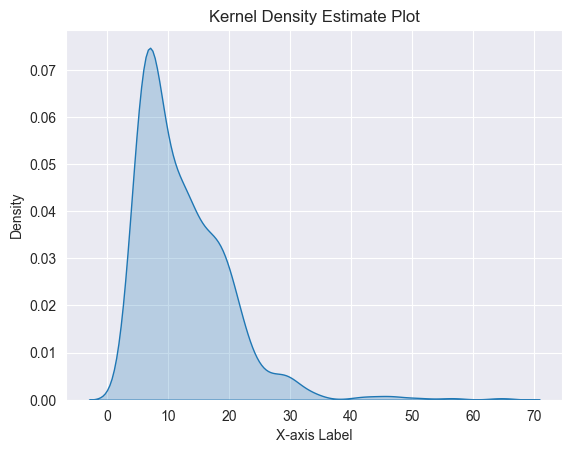

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example data (replace with your actual data)
data = evaluation['score']

# Kernel density estimate plot
sns.kdeplot(data, fill=True)

# Adding labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Density')
plt.title('Kernel Density Estimate Plot')

# Display the plot
plt.show()

In [10]:
import matplotlib.pyplot as plt

horizons = ['36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour']

# for h in horizons:

ax = evaluation[evaluation['horizon'] == '36 hour'].plot(kind='line',  linestyle='-')

# Adding labels and title
plt.xlabel('Forecast Date')
plt.ylabel('Score')
plt.title('Score Over Time: ' + '36 hour')
ax.set_ylim(0, 80)
# Display the plot
plt.show()


KeyError: 'horizon'

In [ ]:
import matplotlib.pyplot as plt

# List of horizons
horizons = ['36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour']

# Plotting all lines in one plot
plt.figure()  # Create a new figure
for h in horizons:
    subset = evaluation[evaluation['horizon'] == h]
    plt.plot(subset.index, subset['score'], label=h)

# Adding labels and title
plt.xlabel('Forecast Date')
plt.ylabel('Score')
plt.title('Score Over Time')

# Setting y-axis limit
plt.ylim(0,55)

# Adding legend
plt.legend(title='Horizon')

# Display the plot
plt.show()

It can be seen that the heavy outliers are 36 and 44 hour. Is it due to workdays (where production is still active) or not active?
==> CHeck for Holydays

YES! The orange outliers seem to be on Karfreitag.

It can also be seen, that 60-68 hour-forecasts seem to have less extreme outliers